<a href="https://colab.research.google.com/github/smfwlgus/DnM/blob/master/baechu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Library Import & Settings**

In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm

import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm
from lightgbm import LGBMRegressor

In [2]:
# 경고 끄기
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings(action='ignore')  #관련없는 문구 알리지 않음

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Capstone/Data/ten_pum_train_onebon.csv')
train = train[:1827] #2016-01-01 ~ 2020-12-31까지의 10개 품목 농산물 데이터 가져오기

In [4]:
weather = pd.read_csv('/content/drive/MyDrive/Capstone/주산지, 날씨 코드/weather.csv')
weather.head() #2015~2020까지 농산물의 날씨 데이터

,no,stn_Code,stn_Name,date,temp,max_Temp,min_Temp,hum,widdir,wind,rain,sun_Time,sun_Qy,condens_Time,gr_Temp,soil_Temp,soil_Wt
0,1,536824B002,해남군 옥천면,2015-01-01,-1.3,0.6,-2.9,80.0,295.2,2.3,0.8,NaN,7.8,NaN,NaN,3.36,25.9
1,1,330846A001,천안시 목천읍,2015-01-01,-6.2,-3.8,-8.3,NaN,NaN,0.0,0.0,NaN,NaN,1429.0,NaN,NaN,NaN
2,1,627911A001,밀양시 상남면,2015-01-01,-3.2,0.2,-7.2,40.1,282.7,2.9,0.0,516.0,11.0,0.0,NaN,2.20,28.5
3,1,539823A001,진도군 군내면,2015-01-01,-0.8,1.6,-2.8,79.2,257.0,3.5,1.5,217.0,8.2,652.0,NaN,5.02,30.6
4,1,590823A001,남원시 이백면,2015-01-01,-4.1,-1.3,-6.0,60.7,286.7,2.1,0.5,310.0,7.7,0.0,-4.3,2.16,20.3


# **전처리 - 이상치, 결측치**

In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34263 entries, 0 to 34262
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   no            34263 non-null  int64  
 1   stn_Code      34263 non-null  object 
 2   stn_Name      34263 non-null  object 
 3   date          34263 non-null  object 
 4   temp          34258 non-null  float64
 5   max_Temp      34258 non-null  float64
 6   min_Temp      34227 non-null  float64
 7   hum           33518 non-null  float64
 8   widdir        30691 non-null  float64
 9   wind          34263 non-null  float64
 10  rain          34255 non-null  float64
 11  sun_Time      23537 non-null  float64
 12  sun_Qy        33610 non-null  float64
 13  condens_Time  28002 non-null  float64
 14  gr_Temp       18895 non-null  float64
 15  soil_Temp     29585 non-null  float64
 16  soil_Wt       17250 non-null  float64
dtypes: float64(13), int64(1), object(3)
memory usage: 4.4+ MB


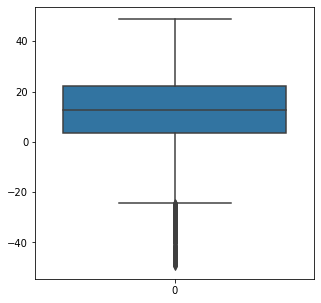

In [ ]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=weather['soil_Wt'])

In [ ]:
weather = weather.drop(['sun_Time', 'condens_Time', 'gr_Temp', 'soil_Wt'] , 1)

In [ ]:
weather.fillna(0, inplace=True)

In [ ]:
weather.isnull().sum()

no           0
stn_Code     0
stn_Name     0
date         0
temp         0
max_Temp     0
min_Temp     0
hum          0
widdir       0
wind         0
rain         0
sun_Qy       0
soil_Temp    0
dtype: int64

# **weather**

In [ ]:
#10개 품목의 주산지
joosan_dict = {
              '깻잎': '경상남도 밀양시',
              '대파': '전라남도 신안군',
              '마늘': '경상남도 창녕군',
              '무': '제주도 제주시',
              '미나리': '경기도 시흥시',
              '배추': '전라남도 해남군',
              '시금치': '경기도 포천시',
              '양파': '전라남도 무안군',
              '토마토': '부산 강서구',
              '파프리카': '강원도 철원군'         
}

In [ ]:
#10개 품목의 주산지 관측지점 코드
code_dict = { 
    '강원도 철원군': '269811A001', #파프리카
    '경기도 시흥시': '429843A001', #미나리
    '경기도 포천시': '487915A001', #시금치
    '경상남도 밀양시': '627911A001', #깻잎
    '경상남도 창녕군': '635821A001', #마늘
    '부산 강서구': '618803A001', #토마토
    '전라남도 무안군': '534833E001', #양파
    '전라남도 신안군': '535812A001', #대파
    '전라남도 해남군': '536824B002', #배추
    '제주도 제주시': '063057B009', #무
}

In [ ]:
first_date = datetime.datetime.strptime('2020-09-28', '%Y-%m-%d') - datetime.timedelta(360) #기준 날짜에서 360일 전 날짜까지 
date_list = [] 
for delta in range(360) : #0~360
    date = first_date + datetime.timedelta(days = delta)
    date = datetime.datetime.strftime(date, '%Y-%m-%d') 
    date_list.append(date)
date_df = pd.DataFrame({'date' : date_list}) #date가 담긴 df 생성

train = pd.read_csv('/content/drive/MyDrive/Capstone/Data/ten_pum_train_onebon.csv')
train = train[:1827] #2016 1 ~ 2020 12
train2 = pd.concat([date_df, train], sort = False).reset_index(drop=True) #1년치, 전체날짜(train)

In [ ]:
pum = '배추'

temp_df = train2[['date',f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']]
    
# 품종과 주산지 날씨 mapping
joosanji = joosan_dict[pum]
joosan_code = code_dict[joosanji]
joosan_weather = allweather[allweather['stn_Code']==joosan_code].reset_index(drop=True)
end_index = np.where(joosan_weather['date']=='2020-12-31')[0][0] 
joosan_weather = joosan_weather.iloc[:end_index+1] #2020-12-31 까지만 자르기
temp_df = temp_df.merge(joosan_weather, on='date', how='left')

# weather feature 추가
col_list = temp_df.columns[6:]
for num in range(1,13) :
  for index in range(360, len(temp_df)) :
    temp_quater_df = temp_df.iloc[index-30*num : index-30*(num-1)] 
    quater_temp = temp_quater_df['temp']

    temp_df.loc[index, f'rain_sum_{num}q'] = temp_quater_df['rain'].sum() # 누적 강수량
    temp_df.loc[index, f'heavy_rain_count_{num}q'] = np.where(temp_quater_df['rain']>90, 1, 0).sum() # 평균 강수량 90mm 이상 누적 일수
    temp_df.loc[index, f'low_temp_count_{num}q'] = np.where(quater_temp<5, 1, 0).sum() # 일평균 기온 5도 이하 누적 일수
    temp_df.loc[index, f'middle_temp_count_{num}q'] = np.where(((quater_temp>15)&(quater_temp<22)), 1, 0).sum() # 일평균 기온 15~22도 누적 일수
    temp_df.loc[index, f'high_temp_count_{num}q'] = np.where(quater_temp>32, 1, 0).sum() # 일평균 기온 32도 이상 누적 일수
    for col in col_list :
                temp_df.loc[index, f'avg_{col}_{num}q'] = temp_quater_df[col].mean() # 각 기상 요소의 평균값
    
# 예측 대상(1w,2w,4w) 추가
for week in ['1_week','2_week','4_week'] :
  temp_df[week] = 0
  n_week = int(week[0])
  for index in range(len(temp_df)) :
    try : temp_df[week][index] = temp_df[f'{pum}_가격(원/kg)'][index+7*n_week]
    except : continue
    
drop_col_list = temp_df.columns[3:19]
temp_df = temp_df.drop(drop_col_list, 1).reset_index(drop=True)
temp_df = temp_df.iloc[360:].reset_index(drop=True)
temp_df = temp_df.drop(['date',f'{pum}_거래량(kg)',f'{pum}_가격(원/kg)'], axis=1)
    
temp_df

# **학습**

In [ ]:
#nmae사용 
def nmae(week_answer, week_submission):
    answer = week_answer.to_numpy()
    target_idx = np.where(answer!=0)
    true = answer[target_idx]
    pred = week_submission[target_idx]
    score = np.mean(np.abs(true-pred)/true)
    
    return score

#1,2,4주의 평균으로 예측
def at_nmae(pred, dataset):
    y_true = dataset.get_label()
    week_1_answer = y_true[0::3]
    week_2_answer = y_true[1::3]
    week_4_answer = y_true[2::3]
    
    week_1_submission = pred[0::3]
    week_2_submission = pred[1::3]
    week_4_submission = pred[2::3]
    
    score1 = nmae(week_1_answer, week_1_submission)
    score2 = nmae(week_2_answer, week_2_submission)
    score4 = nmae(week_4_answer, week_4_submission)
    
    score = (score1+score2+score4)/3
    
    return 'score', score, False

In [ ]:
def model_train(x_train, y_train, x_valid, y_valid) :
    params = {'learning_rate': 0.01, #학습률
              'max_depth': 6, #트리의 최대 깊이
              'boosting': 'gbdt', #실행하고자 하는 알고리즘 타입. 현재 디폴트 값인 gradient boosting decision tree
              'objective': 'regression',  #모델 어플리케이션. 현재 regression(회귀) --------------------------------------> 분류로도 해서 성능 비교하기*******
              'is_training_metric': True, 
              'num_leaves': 100, #전체 트리의 leave 수
              'feature_fraction': 0.8, #Light GBM이 트리를 만들 때 매번 각 iteration 반복에서 파라미터 80% 랜덤 선택
              'bagging_fraction': 0.8, #배깅, 매번 iteraion 돌 때 사용되는 데이터 80% 랜덤 선택
              'bagging_freq': 5, #배깅 빈도수
              'seed':42, #랜덤 시드
              'num_threads':8
             }
    #모델 Light GBM
    model = lightgbm.train(params, 
                   train_set = lightgbm.Dataset(data = x_train, label = y_train),
                   num_boost_round = 10000, #boosting iteraion 수. 10,000회
                   valid_sets = lightgbm.Dataset(data = x_valid, label = y_valid), #validation 세트 -> data에 x검증, label에 y검증
                   init_model = None, 
                   early_stopping_rounds = 100, #분석 속도 높이기. 지나친 iteration 줄이기
                   feval = at_nmae,
                   verbose_eval = False
                    )
    
    return model

In [ ]:
model_dict = {} #배추만 학습시켜보기
split = 28 #전체 100 중 validation용으로 나눔

# 주차별(1,2,4w) 학습
for week_num in [1,2,4] :
  x = temp_df[temp_df[f'{week_num}_week']>0].iloc[:,:-3] 
  y = temp_df[temp_df[f'{week_num}_week']>0][f'{week_num}_week']
        
  #train, test split
  x_train = x[:-split]
  y_train = y[:-split]
  x_valid = x[-split:]
  y_valid = y[-split:]
        
  model_dict[f'{pum}_model_{week_num}'] = model_train(x_train, y_train, x_valid, y_valid)

KeyError: ignored

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Capstone/Data/subsub.csv') #2021-12-03까지 예측 가능

public_date_list = submission[submission['예측대상일자'].str.contains('2021')]['예측대상일자'].str.split('+').str[0].unique()
#['2021-01-01', ...] 

for date in tqdm(public_date_list) : #빈 submission 파일 불러오기
  test = pd.read_csv(f'/content/drive/MyDrive/Capstone/Data/test_files/test_{date}.csv') 

  # 예측기준일에 대해 전처리
  temp_test = pd.DataFrame([{'date' : date}]) #test_files에 있는 예측기준일(date)
  alldata = pd.concat([train, test, temp_test], sort=False).reset_index(drop=True) 
  #[train, test, temp_test연결], sort 기본값, reset_index(drop=True)는 이전 인덱스가 열로 추가되는 것 방지  
  alldata = alldata[['date', f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']].fillna(0) #모든 데이터에서 값이 없는 부분(na) -> 0으로 채우기 
  #alldata = alldata.iloc[-28:].reset_index(drop=True) #-28(마지막) 가져오기, drop=True는 인덱스 열 버리기
  alldata = alldata[:-1]
  
  #alldata = preprocessing(alldata, pum, len_lag=28) #전처리(모든 데이터, pum, 28) *수정필요*
  #temp_df = alldata[['date',f'{pum}_거래량(kg)', f'{pum}_가격(원/kg)']]
  alldata = weather_feature(alldata, temp_test, weather, pum, joosan_dict, code_dict, quater_days=30, num_quaters=12) #날씨 전처리로 추가, temp_df 지움
  #alldata = temp_df

  temp_test = alldata.iloc[-1].astype(float) #iloc[-1], 마지막 행을 float 타입으로 가져오기
          
  # 개별 모델을 활용하여 1,2,4주 후 가격 예측
  for week_num in [1,2,4] : #week_num: 1,2,4
    temp_model = model_dict[f'{pum}_model_{week_num}']
    result = np.round(temp_model.predict(temp_test), 0) #temp_test의 예측값---> train, test,temp_test 다 담아서 예측하는 거
    condition = (submission['예측대상일자']==f'{date}+{week_num}week') #ex.[2020-09-29 + 1week]
    idx = submission[condition].index #인덱스
    submission.loc[idx, f'{pum}_가격(원/kg)'] = result[0] #loc은 레이블 기반이라 행.열 설정해줘야함
    #행 idx, 열은 pum들의 가격(원/kg) 인덱스
    #주차 별로 품목 바꾸면서 가격 가져오기

preds = temp_model.predict(alldata)

# **성능**

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
preds.shape

In [ ]:
alldata = pd.concat([train, test, temp_test], sort=False).reset_index(drop=True) 

In [ ]:
real = train['양파_거래량(kg)'].to_numpy()

In [ ]:
acc = r2_score(real, preds)

In [ ]:
acc

-3.034475205202682